In [1]:
%matplotlib inline

#### libraries and functions

In [ ]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh

In [3]:
def dijkstra(G, start, end=None):
    '''
    dijkstra's algorithm determines the length from `start` to every other 
    vertex in the graph.
    The graph argument `G` should be a dict indexed by nodes.  The value 
    of each item `G[v]` should also a dict indexed by successor nodes.
    In other words, for any node `v`, `G[v]` is itself a dict, indexed 
    by the successors of `v`.  For any directed edge `v -> w`, `G[v][w]` 
    is the length of the edge from `v` to `w`.
        graph = {'a': {'b': 1}, 
                 'b': {'c': 2, 'b': 5}, 
                 'c': {'d': 1},
                 'd': {}}
    Returns two dicts, `dist` and `pred`:
        dist, pred = dijkstra(graph, start='a') 
    
    `dist` is a dict mapping each node to its shortest distance from the
    specified starting node:
        assert dist == {'a': 0, 'c': 3, 'b': 1, 'd': 4}
    `pred` is a dict mapping each node to its predecessor node on the
    shortest path from the specified starting node:
        assert pred == {'b': 'a', 'c': 'b', 'd': 'c'}
    
    '''
    inf = float('inf')
    D = {start: 0}          # mapping of nodes to their dist from start
    Q = PQDict(D)           # priority queue for tracking min shortest path
    P = {}                  # mapping of nodes to their direct predecessors
    U = set(G.keys())       # unexplored nodes

    while U:                                    # nodes yet to explore
        (v, d) = Q.popitem()                    # node w/ min dist d on frontier
        D[v] = d                                # est dijkstra greedy score
        U.remove(v)                             # remove from unexplored
        if v == end: break

        # now consider the edges from v with an unexplored head -
        # we may need to update the dist of unexplored successors 
        for w in G[v]:                          # successors to v
            if w in U:                          # then w is a frontier node
                d = D[v] + G[v][w]              # dgs: dist of start -> v -> w
                if d < Q.get(w, inf):
                    Q[w] = d                    # set/update dgs
                    P[w] = v                    # set/update predecessor

    return D, P

In [4]:
def shortest_path(G, start, end):
    dist, pred = dijkstra(G, start, end)
    v = end
    path = [v]
    while v != start:
        v = pred[v]
        path.append(v)        
    path.reverse()
    return path

In [5]:
def make_graph(nodes, triangles):
    #initiate empty graph
    G={}
    for node in range(nodes.shape[0]):
        # initiate entry for this node and empty lists for neighbours derived from each face and all neighbours
        G[node]={}
        n=[]
        all_n=[]
        for tri in range(triangles.shape[0]):
            # get all triangles that contain node
            if node in triangles[tri]:
                # make a list containing the two other nodes of that triangle
                n=list(triangles[tri])
                n.remove(node)
                # append these neighbours to all neighbours if not already contained
                [all_n.append(x) for x in n if x not in all_n]
    
        for neigh in all_n:
            # for all neighbouring nodes compute the distance
            dist=0
            src = nodes[node]
            trg = nodes[neigh]   
            dist=np.linalg.norm(src-trg)
            # append to graph
            G[node][neigh]=dist
            
    return G

#### read and convert data

In [6]:
mesh='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_lh_d.vtk'

In [7]:
v,f,d=read_vtk(mesh)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)

In [8]:
G=make_graph(vertices, faces)

## path and windows

The graph representation of the surface is used to find the shortest path between the chosen source and target node. For each node on the path a window is created containing all other nodes that lie within a given radius and are closer to this node that to any other node on the path. These single node windows are then combined into a larger window with the chosen width that is sliding along the path (for now with step=1 node).

In [18]:
radius=10
width=3
source=46644
target=59276

In [12]:
path=shortest_path(G,source,target)

In [17]:
#np.save('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy', np.asarray(path))

In [ ]:
# for each vertex show only those vertices in the sparse matrix, that have a distance < radius
# for these give the precise distance
inradius_matrix=gdist.local_gdist_matrix(vertices, faces, max_distance=radius)

In [13]:
# get only the vertices that are in a distance < radius to any node in path
inradius_path=[]
for pnode in path:
    inradius_path=list(np.unique(inradius_matrix[:,path].indices))

In [14]:
# make an array with the radius neighbours in columns and the path nodes in rows
path_x_neighbours=np.zeros((len(inradius_path), len(path)))
for pnode in range(len(path)):
    path_x_neighbours[:,pnode]=np.reshape(inradius_matrix[inradius_path,path[pnode]].toarray(),(len(inradius_path),))
path_x_neighbours[path_x_neighbours==0]=np.nan

In [15]:
# for each vertex in this list, find the node on path it is closest to
path_x_neighbours_min=np.zeros((len(inradius_path),1))
for nnode in range(len(inradius_path)):
    path_x_neighbours_min[nnode]=np.nanargmin(path_x_neighbours[nnode,:])

In [16]:
#for each node on the path, extract those neighbour nodes, that fall into its window
windows=[]
for pnode in range(len(path)):
    window=[path[pnode]]
    indices = [i for i, x in enumerate(list(path_x_neighbours_min)) if x == pnode]
    [window.append(inradius_path[y]) for y in indices]
    windows.append(window)

In [17]:
# combine single windows for sliding
combined_windows=[]
for window in range(len(windows)):
    combined_window=[]
    for k in range((window-width),(window+width)):
        if (k>=0) and (k<=len(windows)-1):
            combined_window+=windows[k]
    combined_windows.append(combined_window)

#### get windows back to surface space

In [18]:
# construct a full surface for each window, with only the window nodes set to 1
window_surfs=[]
for combined_window in range(len(combined_windows)):
    window_surf=np.zeros((len(vertices),))

    for j in path:
        window_surf[j]=1
        
    for i in combined_windows[combined_window]:
        window_surf[i]=100
    window_surfs.append(window_surf)

In [19]:
# construct single surface with all windows differently carrying a different number
allwindow_surf=np.zeros((len(vertices),))
for window in range(len(windows)):
        
    for i in windows[window]:
        allwindow_surf[i]=window+2
        
#    for j in path:
#        allwindow_surf[j]=1

#### save and display

In [20]:
# write the all window surface to vtk
#write_vtk(outmesh, vertices, faces, np.reshape(allwindow_surf, (allwindow_surf.shape[0],1)))

## connectivity data

In [21]:
rest='/scr/ilz3/myelinconnect/final_struct_space/rest1_1_meshsmooth_3/BP4T_lh_mid_simple_0.01_rest_lh_smoothdata.vtk'

In [22]:
rv, rf, rd=read_vtk(rest)

### pearsonr in sliding windows

The correlation matrix is calculated for all nodes. Within each window the correlation vectors are averaged (after Fisher r-to-z transform). The Pearson correlation of the resulting average vectors (after z-to-r transform) is used as a measure of similarity between the connectivity profiles of adjacent windows.

In [23]:
#calculate correlation matrix
R=np.nan_to_num(np.corrcoef(rd))

In [24]:
# r-to-z transform for averaging
Z=np.arctanh(R)
# sample corrvectors per window and average
#corr_windows=[]
corr_avgs=[]
for window in combined_windows:
    corr_window=Z[window]
    corr_avg_z=np.mean(corr_window, 0)
    corr_avg_r=np.tanh(corr_avg_z)
    #corr_windows.append(corr_window)
    corr_avgs.append(corr_avg_r)

In [25]:
r_corr_avgs=[]
p_corr_avgs=[]
for vec in range(len(corr_avgs)-1):
    r,p=stats.pearsonr(corr_avgs[vec], corr_avgs[vec+1])
    r_corr_avgs.append(r)
    p_corr_avgs.append(p)

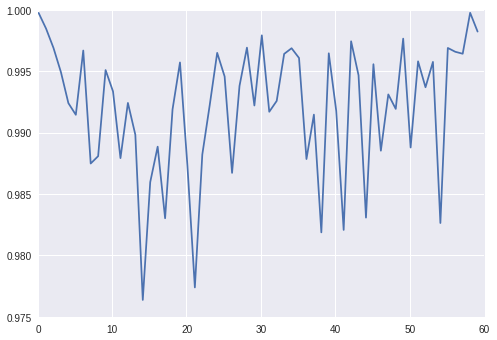

In [26]:
sns.set_style('darkgrid')
plt.plot(r_corr_avgs)

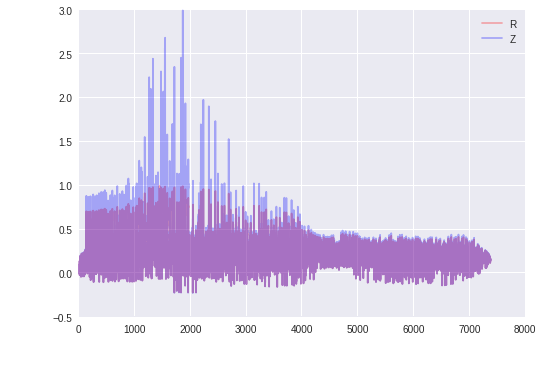

In [27]:
test_window_R=R[combined_windows[3]]
test_window_Z=Z[combined_windows[3]]
plt.plot(test_window_R[0,:], color='red', alpha=0.3, label='R')
plt.plot(test_window_Z[0,:], color='blue', alpha=0.3, label='Z')
plt.legend()

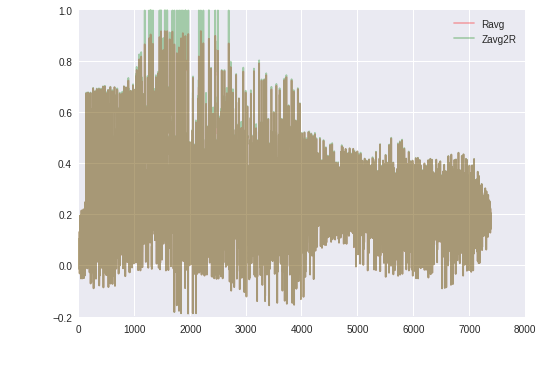

In [28]:
test_window_R_avg=np.mean(test_window_R, 0)
test_window_Z_avg=np.mean(test_window_Z, 0)
test_window_Z_avg_toR=np.tanh(test_window_Z_avg)
plt.plot(test_window_R_avg, color='red', alpha=0.3, label='Ravg')
#plot(test_window_Z_avg, color='blue', alpha=0.3, label='Zavg')
plt.plot(test_window_Z_avg_toR, color='green', alpha=0.3, label='Zavg2R')
plt.legend()

### eta square and comparison along the full path

eta square is an alternative measure to compare the average connectivity profiles across windows. Unlike Pearson correlation it is also sensitive to scaling and offsets (see below). In Cohen 2008 eta square is not only compared in adjacent parts of a path but along the full path to find abrupt changes. Here, eta square is first implemented for the sliding windows and then for the full path. Moreover, the full path approach is tested for the Pearson correlation as a similarity measure, too.

Cohen Neuroimage 2008:
"eta 2 is equal to the fraction of the variance in one signal accounted for by variance in a second signal where comparisons are done on a point by point basis. The more similar two signals, or in this case, images, are the higher the eta 2 coefficient between them. eta 2 can vary in value from 0 (no similarity) to 1 (identical)."
"We use eta 2 to compare images instead of correlation, r, because our goal is to quantify the difference or similarity of the two images, not the correlational relationship between them. While correlation is often used for similarity description, there are instances where the correlation coefficient between images is unaffected by changes in the two images which make them more or less similar from each other. Two examples where this is readily apparent are scaling and offset;"
"To objectively separate the eta 2 profiles into groups hierarchical clustering analysis was performed on the eta 2 profiles to find any strong divisions among the set"
"While there is a general decrease in eta 2 coefficient with distance from the comparison point, abrupt changes are concentrated at specific locations along the line regardless of which initial comparison points are chosen"

In [29]:
# simple eta square calc in sliding windows
eta2_list=[]
for i in range(len(corr_avgs)-1):
    a=corr_avgs[i]
    b=corr_avgs[i+1]
    m=np.mean(np.vstack((a,b)),0) # mean vector
    M=np.mean(m) # grand mean across both vectors

    SSwithin=0
    SStotal=0
    eta2=0
    for node in range(a.shape[0]):
        ssw=np.power((a[node]-m[node]),2)+np.power((b[node]-m[node]),2)
        sst=np.power((a[node]-M),2)+np.power((b[node]-M),2)
        SSwithin+=ssw
        SStotal+=sst
    eta2=1-(SSwithin/SStotal)
    eta2_list.append(eta2)

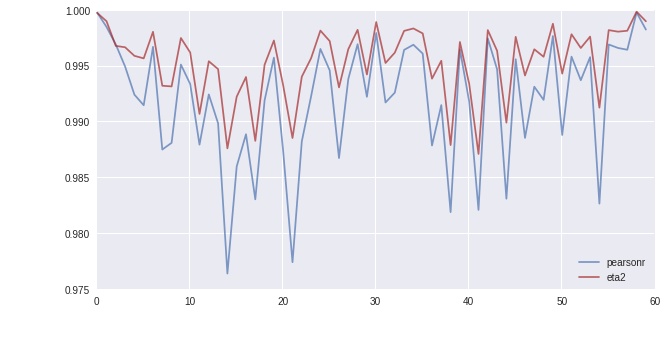

In [30]:
fig=plt.figure(figsize=(10,5))
plt.plot(r_corr_avgs, alpha=0.7, label='pearsonr')
plt.plot(eta2_list, color='brown', alpha=0.7, label='eta2')
plt.legend(loc='lower right')

In [31]:
# eta square across the full path length
def etasquare(correlation_vectors):
    
    eta2_array=np.zeros((len(correlation_vectors), len(correlation_vectors)))
    for i in range(len(correlation_vectors)):
        for j in range(len(correlation_vectors)):
            a=correlation_vectors[i]
            b=correlation_vectors[j]
            m=np.mean(np.vstack((a,b)),0) # mean vector
            M=np.mean(m) # grand mean across both vectors
    
            SSwithin=0
            SStotal=0
            eta2=0
            for node in range(a.shape[0]):
                ssw=np.power((a[node]-m[node]),2)+np.power((b[node]-m[node]),2)
                sst=np.power((a[node]-M),2)+np.power((b[node]-M),2)
                SSwithin+=ssw
                SStotal+=sst
            eta2=1-(SSwithin/SStotal)
            eta2_array[i,j]=eta2
    return eta2_array

In [32]:
eta2_windows=etasquare(corr_avgs)

In [33]:
#same approach for correlations
def corrcorr(correlation_vectors):
    
    corrcorr_array=np.zeros((len(correlation_vectors), len(correlation_vectors)))
    for i in range(len(correlation_vectors)):
        for j in range(len(correlation_vectors)):                      
            a=correlation_vectors[i]
            b=correlation_vectors[j]
            r,p=stats.pearsonr(a,b)
            corrcorr_array[i,j]=r
    return corrcorr_array

In [34]:
corrcorr_windows=corrcorr(corr_avgs)

In [35]:
sns.set_context('poster')

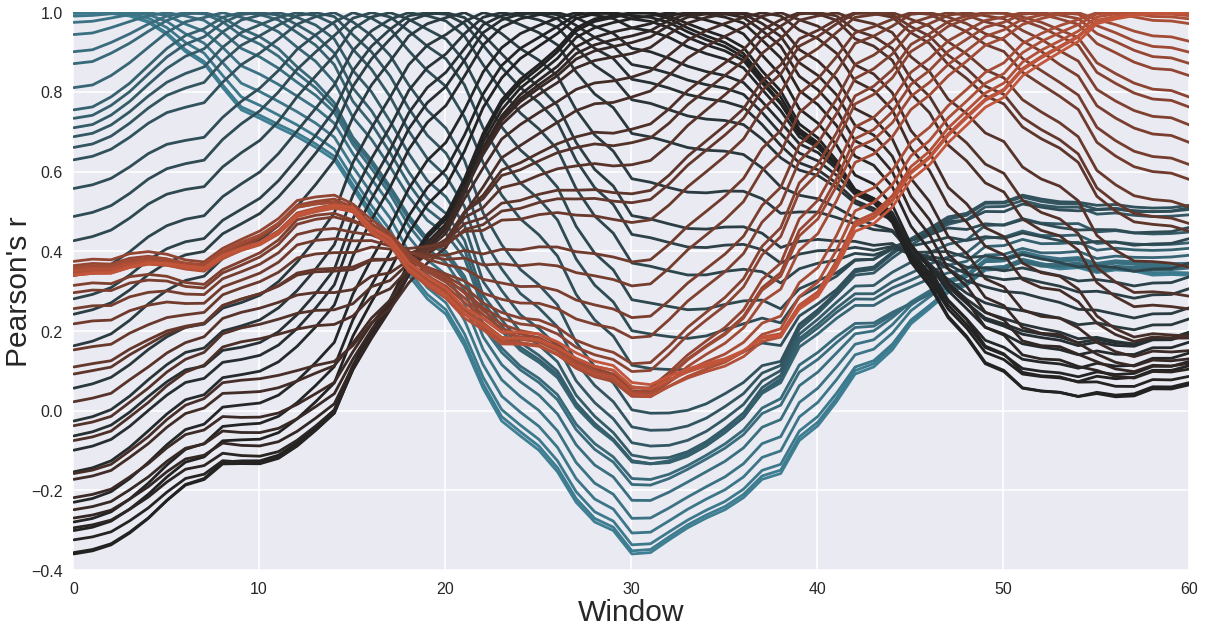

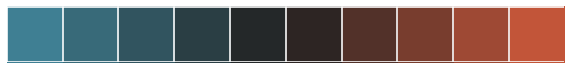

In [36]:
#plotting
etamap=np.array(sns.diverging_palette(220, 20, n=61, center='dark'))
fig=plt.figure(figsize=(20,10))
#ax=fig.add_subplot(1,1,1)
#for w in range(len(eta2_windows)):
#    r=etamap[w][0]
#    g=etamap[w][1]
#    b=etamap[w][2]
#    ax.plot(eta2_windows[w], color=(r,g,b), label='eta2 '+str(w))
#plt.xlabel('window', fontsize=20)
#plt.ylabel('eta2', fontsize=20)
#ylim((-0.4,1))

ax2=fig.add_subplot(1,1,1)
for w in range(len(corrcorr_windows)):
    r=etamap[w][0]
    g=etamap[w][1]
    b=etamap[w][2]
    ax2.plot(corrcorr_windows[w], color=(r,g,b), label='eta2 '+str(w))
plt.xlabel('Window', fontsize=30)
plt.ylabel("Pearson's r", fontsize=30)
plt.ylim((-0.4,1))

sns.palplot(sns.diverging_palette(220, 20, n=10, center='dark'))

## t1 average values

As a first approach to assessing T1 difference along the path, for each node the average cortical T1 value, excluding outer and innermost layers (=layer 3to7 of 11) to reduce partial volume effects, is sampled. For each window the mean and variance are calculated and compared along the path. In principal, peak variances could indicate aprupt changes in the T1 pattern. However, the average T1 value is a very rough measure to describe cortical architecture and using the shape of the T1 profiles across the cortex (see below) might be the better approach. 

In [37]:
t1='/scr/ilz3/myelinconnect/final_struct_space/t1_smooth_1.5_mesh/BP4T_lh_mid_simple_0.01_t1_smooth1.5_lh.vtk'

In [38]:
tv, tf, td =read_vtk(t1)

In [39]:
# sample t1 per window, calc mean and variance
t1_windows=[]
t1_means=[]
t1_vars=[]
for window in combined_windows:
    t1_window=td[window]
    t1_mean=t1_window.mean()
    t1_var=t1_window.var()
    
    t1_windows.append(t1_window)
    t1_means.append(t1_mean)
    t1_vars.append(t1_var)

In [40]:
t1plot_list=[]
for n in range(len(t1_windows)):
    t1plot_list+=[np.reshape(t1_windows[n], (t1_windows[n].shape[0],))]

## t1 profiles

The average T1 profiles per window are approximated using Chebychev polynomials. The resulting coefficients are used as a feature vector to assess the distance between windows. As opposed to the features used in the observer-independent parcellation approach in Schleicher, Neuroimage 1999 this accounts for the actual geometric shape of the profile instead of interpreting them as frequency curves.  To quantify the distance between adjacent windows, the Jensen-Shannon divergence of the SSQ between the coefficient vectors is calculated. This statistic is preferable to the Hotteling test as the latter has a high false positive rate.

In [41]:
t1_profiles='/scr/ilz3/myelinconnect/working_dir/profile_sampling/exp-0000/exp-0000-A/SurfaceMeshMapping/BP4T_lh_mid_simple_0.01_profiles.vtk'

In [42]:
profv, proff, profd =read_vtk(t1_profiles)

In [43]:
#average profiles within windows
prof_avgs=[]
for window in combined_windows:
    prof_window=profd[window]
    prof_avg=np.mean(prof_window, 0)
    prof_avgs.append(prof_avg)

In [44]:
w=30
x=np.array(range(len(prof_avgs[w])))
#y=prof_avgs[w]
y=profd[345]

### Approximation with Chebychev polynomials

In [45]:
cheb5=np.polynomial.chebyshev.chebfit(x, y, 5)
cheb10=np.polynomial.chebyshev.chebfit(x, y, 10)
cheb20=np.polynomial.chebyshev.chebfit(x, y, 20)
cheb30=np.polynomial.chebyshev.chebfit(x, y, 30)

/home/raid3/huntenburg/workspace/try_openblas/local/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1761: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


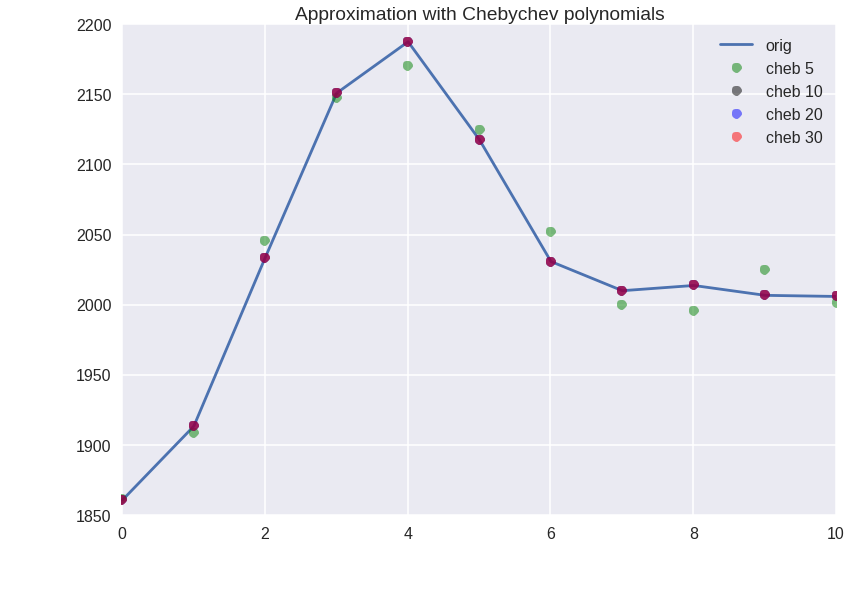

In [46]:
plt.plot(y, label='orig')
plt.plot(np.polynomial.chebyshev.chebval(x, cheb5), color='green',label='cheb 5', linestyle='None', marker='o', markersize=10, alpha=0.5)
plt.plot(np.polynomial.chebyshev.chebval(x, cheb10), color='black', label='cheb 10', linestyle='None', marker='o', markersize=10, alpha=0.5)
plt.plot(np.polynomial.chebyshev.chebval(x, cheb20), color='blue', label='cheb 20', linestyle='None', marker='o', markersize=10, alpha=0.5)
plt.plot(np.polynomial.chebyshev.chebval(x, cheb30), color='red', label='cheb 30', linestyle='None', marker='o', markersize=10, alpha=0.5)
plt.legend()
plt.title('Approximation with Chebychev polynomials')

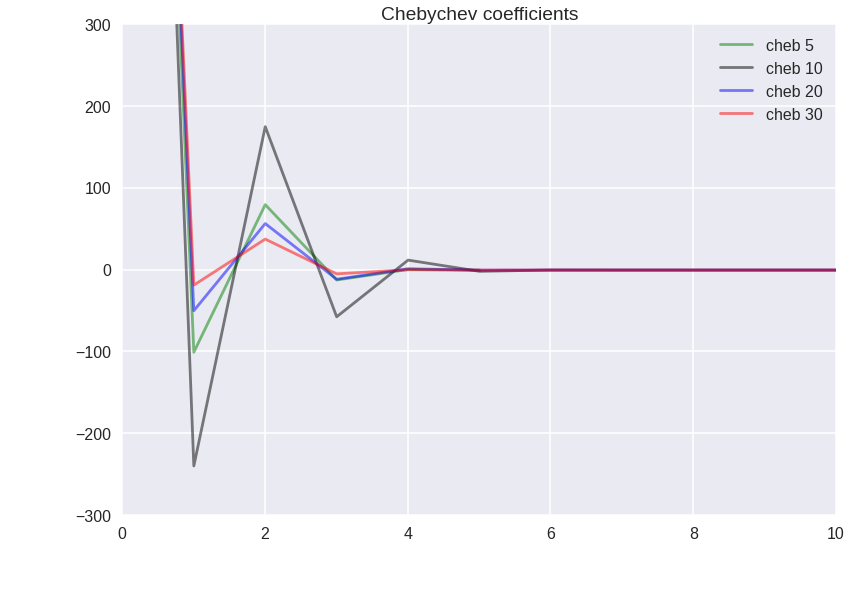

In [47]:
plt.plot(cheb5, color='green',label='cheb 5', alpha=0.5)
plt.plot(cheb10, color='black', label='cheb 10', alpha=0.5)
plt.plot(cheb20, color='blue', label='cheb 20', alpha=0.5)
plt.plot(cheb30, color='red', label='cheb 30', alpha=0.5)
plt.legend()
plt.xlim(0,10)
plt.ylim(-300,300)
plt.title('Chebychev coefficients')

In [48]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

In [49]:
cheb_coeffs, cheb_polynoms=chebapprox(prof_avgs, 20)

In [50]:
fig=figure(figsize(10,10))
for c in range(cheb_polynoms.shape[0]):
    r=etamap[c][0]
    g=etamap[c][1]
    b=etamap[c][2]
    plt.plot(cheb_polynoms[c], color=(r,g,b,0.6))
plt.xlabel('window', fontsize=15)
plt.ylabel('T1', fontsize=15)
sns.palplot(sns.diverging_palette(220, 20, n=12, center='dark'))

NameError: name 'figure' is not defined

### euclidian distance between chebychev coefficients

In [ ]:
euclid_list=[]
for w in range(len(combined_windows)-1):
    diff=sp.spatial.distance.euclidean(cheb_coeffs[w],cheb_coeffs[w+1])
    euclid_list.append(diff)

In [ ]:
sns.set_context('notebook', font_scale=1.5)
fig = plt.figure(figsize=(15,10))

euclidplot=fig.add_subplot(2,1,1)
plt.plot(euclid_list)
euclidplot.set_xlim([0, len(windows)])
euclidplot.set_xticks(range(0, len(combined_windows), 2))
sns.axlabel('','euclidian distance \nchebychev coefficients', fontsize=20)

corr=fig.add_subplot(2,1,2)
plt.plot(r_corr_avgs)
corr.set_xlim([0,len(windows)])
corr.set_xticks(range(0, len(combined_windows), 2))
sns.axlabel('','corr', fontsize=20)

In [ ]:
def euclid(coeffs):
    euclid_array=np.zeros((coeffs.shape[0], coeffs.shape[0]))
    for i in range(coeffs.shape[0]):
        for j in range(coeffs.shape[0]):
            euclid_array[i,j]=sp.spatial.distance.euclidean(cheb_coeffs[i],cheb_coeffs[j])
    return euclid_array

In [ ]:
euclid_windows=euclid(cheb_coeffs)

In [ ]:
#plotting
etamap=np.array(sns.diverging_palette(245, 10, n=61, center='dark'))
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(2,1,1)
for s in range(len(euclid_windows)):
    r=etamap[s][0]
    g=etamap[s][1]
    b=etamap[s][2]
    ax.plot(euclid_windows[s], color=(r,g,b))
plt.xlabel('window', fontsize=15)
plt.ylabel('euclidian distance \nchebychev coefficients', fontsize=15)

sns.palplot(sns.diverging_palette(245, 10, n=17, center='dark'))


### Comparisons with Jensen-Shannon divergence

The Jensen-Shannon divergence measures the similarity of two probability functions, roughly the amount of information lost when one function is approximated by the other. It is derived from the Kullback-Leibler divergence however as compared to that has the advantage of being symmetric and always finite.

adapted from 
stackoverflow http://stats.stackexchange.com/questions/29578/jensen-shannon-divergence-calculation-for-3-prob-distributions-is-this-ok
& scipy open PR https://github.com/scipy/scipy/pull/3213

In [ ]:
import numpy as np
# @author: jonathanfriedman

def jensenshannon(x,y): #Jensen-shannon divergence
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    x=x/x.sum()
    y=y/y.sum()
    m = (x + y)/2.
    m = np.where(m,m,1.)
    d1 = x*np.log2(2*x/m)
    d2 = y*np.log2(2*y/m)
    d1[np.isnan(d1)] = 0
    d2[np.isnan(d2)] = 0
    d = 0.5*np.sum(d1+d2)    
    return d

### next steps / questions

* implement different overlap of windows
* t1 avg profiles or coefficients? comparing profiles or coefficients?
* js
* degree of chebychev?
* Is non-independence of overlapping windows addressed? Is the overlap a good idea?